# Decision Tree Regression (RandomForrest)

## Import + functions

In [248]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV

time_start = time.time()

def fit_and_predict(model, X_train, y_train, X_test):
    model.fit(X_train, y_train)
    return model.predict(X_train), model.predict(X_test)

def create_model(X_train, features, model, ordinal=False):
    numeric_features = []
    categorical_features = []
    for feature in features:
        if X_train[feature].dtypes in ['int64', 'float64']:
            numeric_features.append(feature)
        else:
            categorical_features.append(feature)
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
    ])
    if ordinal:
        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
        ])
    else:
        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
            
        ])
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )
    return Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

def print_table(table: list):

    display_size = 50

    col_size = []
    to_verif_index = []
    tab_size = 0
    for i in range(len(table[0])):
        col_size.append(0)
        for j in range(len(table)):
            col_size[i] = max(len(str(table[j][i])), col_size[i])
        if (col_size[i] + 6) > (display_size/(len(table[0]))):
            to_verif_index.append(i)
        else:
            tab_size += col_size[i]
    display_size -= tab_size + 4 * len(col_size)
    nb = len(to_verif_index)
    for index in to_verif_index:
        col_size[index] = min(col_size[index], int(display_size/nb))
        tab_size += col_size[index]

    buffer = ""
    line = "╞"
    first_line = "╭"
    end_line = "╰"

    for i in range(len(table[0])):
        elt = table[0][i]
        if len(str(elt)) > col_size[i]:
            elt = elt[0:(col_size[i]-1)] + "…"
        buffer += ("│ {:^" + str(col_size[i]) + "} ").format(elt)
        line += ("═{:^" + str(col_size[i]) + "}═╪").format(col_size[i]*'═')
        first_line += ("─{:^" + str(col_size[i]) + "}─┬").format(col_size[i]*'─')
        end_line += ("─{:^" + str(col_size[i]) + "}─┴").format(col_size[i]*'─')
    buffer += "│"
    line = line[:-1] + "╡"
    first_line = first_line[:-1] + "╮"
    end_line = end_line[:-1] + "╯"

    print(first_line)
    print(buffer)
    print(line)
    buffer = ""

    table = table[1:]
    for i in range(len(table)):
        for j in range(len(table[i])):
            elt = str(table[i][j])
            if len(elt) > col_size[j]:
                elt = elt[:(col_size[j]-1)] + "…"
            buffer += ("│ {:" + str(col_size[j]) + "} ").format(str(elt))
        buffer += "│\n"
    if len(buffer) > 0:
        print(buffer[:-1])
    print(end_line)


## Parameters

In [249]:
## Paths
data_folder = 'resources/data/'
output_folder = 'output/'
plots_folder = 'output/plots/'

## Multithreading parameters
num_threads = os.cpu_count()

## Target
target = 'LotArea'

## Parameters of output
predict_mode = False # If True, the output is the submission file for Kaggle competition
plot_activated = True
boxenplot_activated = False 
save_plots = False # If True, the plots are saved in the plots folder

## Parameters of the data
poly_features_activated = False
outliers_removal = True 
random_split = 5
trunc = 0.8

#Parameters of features selection
dynamic_features = False
max_features = 35

#Parameters of the models
dynamic_hyperparameters = False

## Train Data Loading

In [250]:
df = pd.read_csv(data_folder + 'train.csv')
df[df.select_dtypes(exclude='number').columns] = df.select_dtypes(exclude='number').astype('category')

print(df.shape)
print(df.dtypes)

(1459, 79)
MSSubClass          int64
MSZoning         category
LotFrontage       float64
LotArea             int64
Street           category
                   ...   
MiscVal             int64
MoSold              int64
YrSold              int64
SaleType         category
SaleCondition    category
Length: 79, dtype: object


## Density plot of Target

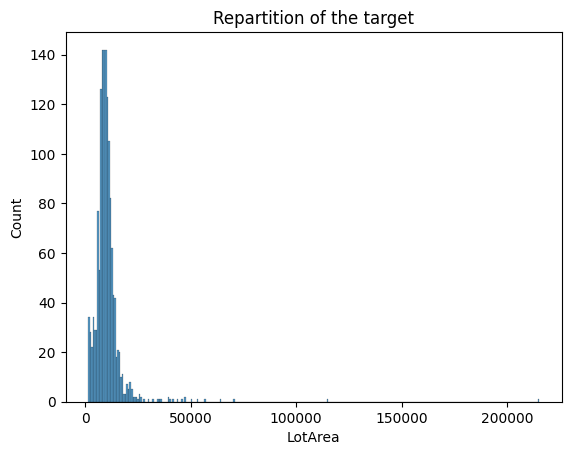

19041.67999999995


In [251]:
# Target repartition
if plot_activated:
    sns.histplot(df[target])
    plt.title('Repartition of the target')
    plt.show()
    print(df[target].quantile(0.96))

## Test Data loading

In [252]:
if predict_mode:
    # Load the test features and drop the column ID, which is only useful for the submission
    X_test = pd.read_csv(data_folder + 'test.csv')
    X_test_id = X_test['ID']
    X_test = X_test.drop(columns='ID')
    X_train = df.drop(columns=target)
    y_train = df[target]

## Experiment Data Splitting

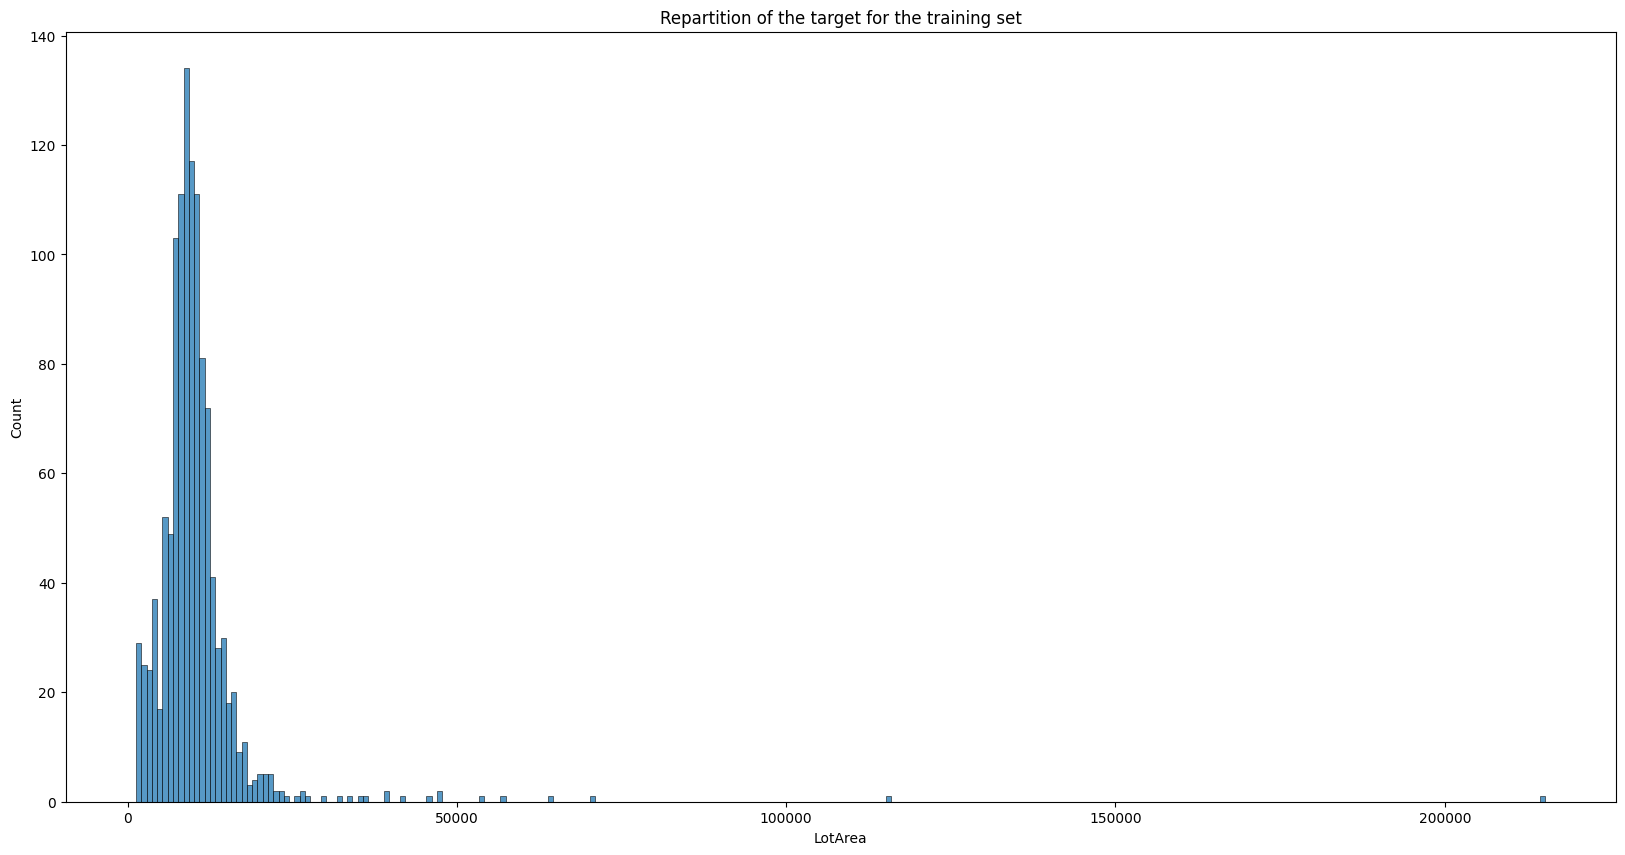

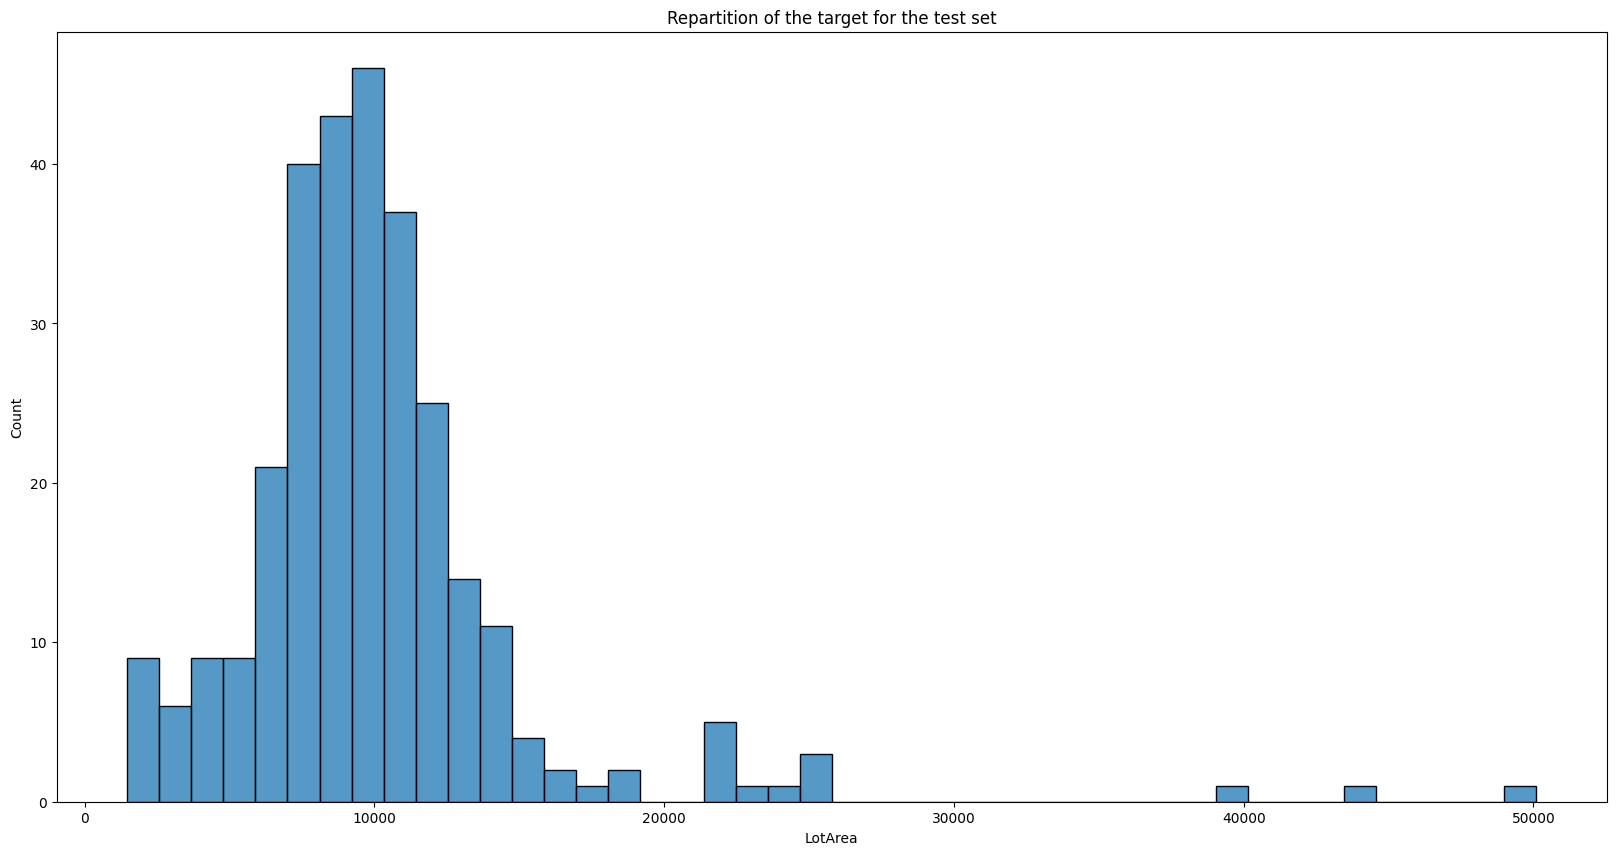

In [253]:
# Load the training dataset and define the features and target
if not predict_mode:
    X_train, X_test, y_train, y_test = train_test_split(df.drop(target, axis=1), df[target], train_size=trunc, test_size=1-trunc, shuffle=True, random_state=random_split)

plt.figure(figsize=(20, 10))
sns.histplot(y_train)
plt.title('Repartition of the target for the training set')
plt.show()

if not predict_mode:
    plt.figure(figsize=(20, 10))
    sns.histplot(y_test)
    plt.title('Repartition of the target for the test set')

## Feature Selection + Data Cleaning

In [254]:
if outliers_removal:
    df = pd.concat([X_train, y_train], axis=1)
    df = df[df[target] < 80000]
    X_train = df.drop(target, axis=1)
    y_train = df[target]
    
# Dynamic selection of features
def select_features(df, target):
    model = create_model(df, df.drop(target, axis=1).columns.to_list(), model=RandomForestRegressor(n_estimators=500, n_jobs=num_threads), ordinal=True)
    model.fit(X_train, y_train)
    feature_importances = model.named_steps['model'].feature_importances_
    feature_importances = pd.DataFrame({
        'feature': X_train.columns.tolist(),
        'importance': feature_importances
    })
    feature_importances = feature_importances.sort_values(by='importance', ascending=False)
    selected_features = feature_importances['feature'].head(n=max_features).tolist()
    return selected_features

if dynamic_features:
    selected_features = select_features(df, target)
else:
    # Best features after lot of tests (boxenplots, etc.)
    selected_features = ['TotRmsAbvGrd','LotFrontage', 'MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape',  'Neighborhood', 'YearBuilt', 'TotalBsmtSF', 'Heating', 'GrLivArea', 'GarageArea']


## BoxenPlots

In [255]:
if plot_activated and boxenplot_activated:
    num_quantiles = 20
    for column in df.columns.tolist():
        if column in selected_features:
            plt.figure(figsize=(20, 12))
            if df[column].dtype in ['int64', 'float64']:
                categories = pd.cut(df[column], bins=num_quantiles)
                sns.boxenplot(x=categories, y=df[target], color='blue')
            else:
                sns.boxenplot(x=X_train[column], y=df[target], color='blue')
            plt.title(f"Boxenplot of {column}")
            if save_plots:
                plt.savefig(f"{plots_folder}boxenplots_choosed/boxenplot_{column}.png")
            else:
                plt.show()
            plt.clf()


## Preprocessing

In [256]:
def get_params(X_train, y_train, model, grid_params):
    selected_features = X_train.columns.tolist()
    model = create_model(X_train, selected_features, RandomizedSearchCV(model, grid_params, cv=5, n_jobs=num_threads, n_iter=100))
    model.fit(X_train, y_train)
    print(model.get_params()['model'].best_params_)
    return model.get_params()['model'].best_params_


if dynamic_hyperparameters:
    rf_grid_params = {
        'n_estimators': [100, 200, 300, 400, 500],
        'max_features': ['sqrt', 'log2'],
        'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False],
        'criterion': ['squared_error'],
        'random_state': [i for i in range(1, 100)]
    }
    rf_params = get_params(df.drop(columns=target), df[target], RandomForestRegressor(), rf_grid_params)
else:
    rf_params = {
    'n_estimators': 500,
    'min_samples_split': 5,
    'min_samples_leaf': 1,
    'max_features': 'sqrt',
    'criterion':'poisson',
    'bootstrap': True,
    'n_jobs': num_threads,
    'random_state': 4
    }

model = create_model(X_train, selected_features, RandomForestRegressor(**rf_params))

## Fitting and prediction

In [257]:
y_train_pred, y_pred = fit_and_predict(model, X_train, y_train, X_test)

## Submission

In [258]:
if predict_mode:
    submission = pd.DataFrame({
        'ID': X_test_id,
        target: y_pred,
    })
    submission.to_csv(output_folder+'submission.csv', index=False)
    print(submission)

## Experiment

╭─────────────────────────┬──────────╮
│          Time           │  1.91 s  │
╞═════════════════════════╪══════════╡
│ Kaggle Score            │ 0.24691  │
│ MSE Test                │ 128.6303 │
│ MSE train               │ 54.6578  │
│ To be near to 1         │ 0.4249   │
│ Erreur absolue moyenne  │ 1987.93  │
│ Erreur absolue maximale │ 34625.95 │
│ Erreur absolue minimale │ 11.56    │
╰─────────────────────────┴──────────╯


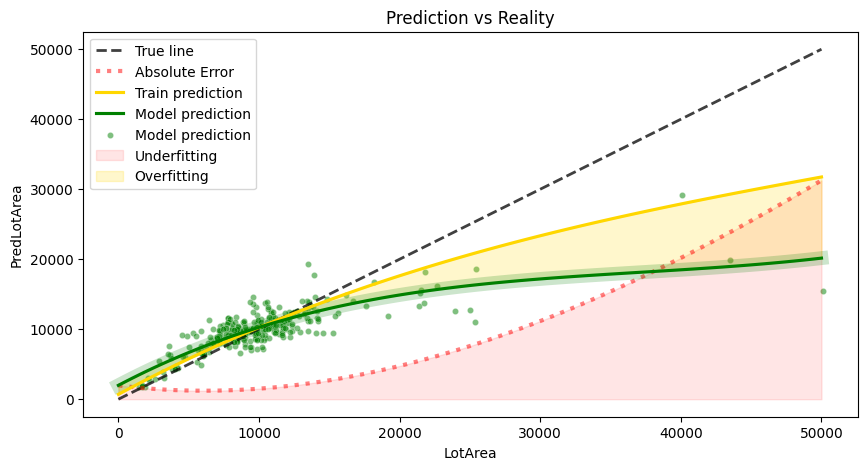

In [259]:
if not predict_mode:
    score = []
    submission_score = list(zip(y_test, y_pred))
    for elt in submission_score:
        score.append((np.log(elt[0]) - np.log(abs(elt[1])))**2)
    score = np.sqrt(np.mean(score))

    mse_test = mean_squared_error(y_test, y_pred) /100000
    mse_train = mean_squared_error(y_train, y_train_pred)/100000
    min_err = np.min(np.abs(y_test - y_pred))
    rmse = mse_train / mse_test
    mle = np.mean(np.abs(y_test - y_pred))
    max_err = np.max(np.abs(y_test - y_pred))
    result = [
        ['Time', f'{time.time() - time_start:.2f} s'],
        ['Kaggle Score', f'{score:.5f}'],
        ['MSE Test', f'{mse_test:.4f}'],
        ['MSE train', f'{mse_train:.4f}'],
        ['To be near to 1', f'{rmse:.4f}'],
        ['Erreur absolue moyenne', f'{mle:.2f}'],
        ['Erreur absolue maximale', f'{max_err:.2f}'],
        ['Erreur absolue minimale', f'{min_err:.2f}']
    ]

    print_table(result)

    if plot_activated:
        plt.figure(figsize=(10, 5))
        plt.title('Prediction vs Reality')
        plt.xlabel('LotArea')
        plt.ylabel('PredLotArea')
        plt.plot([0, 50000], [0, 50000], color='black', alpha=0.75, label='True line', ls='--', lw=2)
        
        order = 3
        x = np.linspace(0, 50000, 100)
        t = np.poly1d(np.polyfit(y_train, y_train_pred, order))
        r = np.poly1d(np.polyfit(y_test, np.abs(y_pred-y_test), order))
        p = np.poly1d(np.polyfit(y_test, y_pred, order))

        sns.regplot(order=order, x=x, y=r(x), color='red', label='Absolute Error', scatter=False, line_kws={'alpha': 0.5, 'linestyle': ':', 'animated': True, 'linewidth': 3})
        sns.regplot(order=order, x=x, y=p(x), color='green', scatter=False, line_kws={'alpha': 0.2, 'animated': True, 'linewidth': 10})
        sns.regplot(order=order, x=x, y=t(x), color='gold', label='Train prediction', scatter=False)
        sns.regplot(order=order, x=x, y=p(x), color='green', label='Model prediction', scatter=False)
        sns.scatterplot(x=y_test, y=y_pred, color='green', label='Model prediction', markers='o', alpha=0.5, s=20)

        plt.fill_between(x, r(x), 0, color='red', alpha=0.1, label='Underfitting')
        plt.fill_between(x, p(x), t(x), color='gold', alpha=0.2, label='Overfitting')
        plt.legend().set
        
        if save_plots:
            plt.savefig(plots_folder+'prediction_vs_reality.png')